In [1]:
# 导入必要的库
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print("库导入完成")


库导入完成


In [29]:
# 读取数据文件
with open('results/quick_test_4_results.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print("数据加载完成")
print(f"总查询数: {data['total_queries']}")
print(f"正确路由数: {data['correct_routes']}")
print(f"路由准确率: {data['correct_routes']/data['total_queries']:.2%}")


数据加载完成
总查询数: 138
正确路由数: 120.0
路由准确率: 86.96%


In [30]:
# 提取模型选择统计数据
model_selection_stats = data['model_selection_stats']

# 准备饼状图数据
models = list(model_selection_stats.keys())
counts = list(model_selection_stats.values())


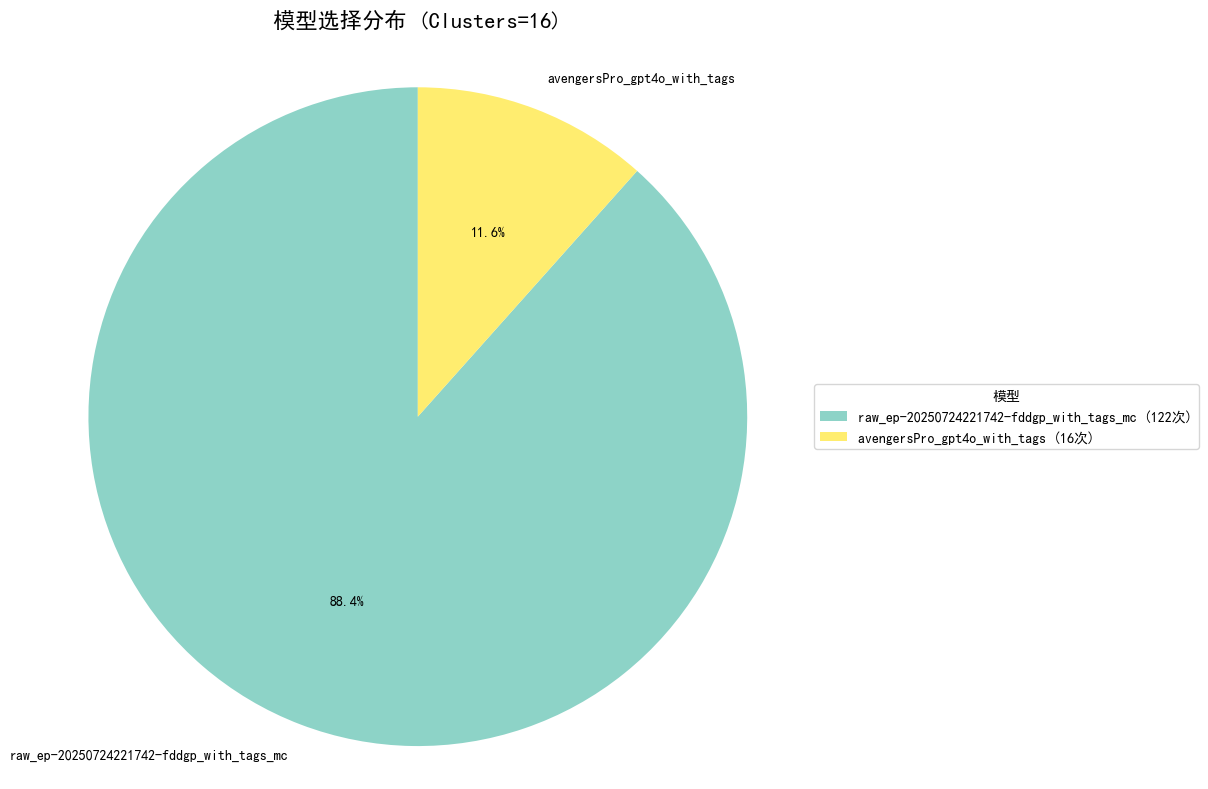

In [31]:
# 绘制饼状图
plt.figure(figsize=(12, 8))

# 定义颜色方案
colors = plt.cm.Set3(np.linspace(0, 1, len(models)))

# 创建饼状图
wedges, texts, autotexts = plt.pie(
    counts, 
    #labels=simplified_names,
    labels=models,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 10}
)

# 设置标题
plt.title('模型选择分布 (Clusters=16)', fontsize=16, fontweight='bold', pad=20)

# 添加图例
legend_labels = [f"{name} ({count}次)" for name, count in zip(models, counts)]
plt.legend(wedges, legend_labels, title="模型", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# 确保饼状图是圆形
plt.axis('equal')

# 调整布局
plt.tight_layout()

# 显示图形
plt.show()

In [32]:
# 从routing_details计算所有模型的准确率
routing_details = data['routing_details']
model_selection_stats = data['model_selection_stats']

# 统计所有模型的表现
model_performance = {}
total_correct = 0
total_queries = len(routing_details)

print(f"分析 {total_queries} 个路由详情...")

# 遍历每个路由记录，计算所有模型在全部查询上的准确率
for record in routing_details:
    is_correct = record['is_correct']
    true_records = record['true_records']
    
    # 统计总体正确率
    total_correct += is_correct
    
    # 统计每个模型的表现
    for model, performance in true_records.items():
        if model not in model_performance:
            model_performance[model] = {'correct': 0, 'total': 0}
        
        model_performance[model]['total'] += 1
        model_performance[model]['correct'] += performance

# 计算准确率
overall_accuracy = total_correct / total_queries
print(f"路由系统总体准确率: {overall_accuracy:.2%}")

# 计算所有模型准确率
all_model_accuracies = {}
for model, stats in model_performance.items():
    accuracy = stats['correct'] / stats['total']
    all_model_accuracies[model] = accuracy

print(f"发现 {len(all_model_accuracies)} 个模型")


分析 138 个路由详情...
路由系统总体准确率: 86.96%
发现 18 个模型


In [34]:
# 计算被选择模型在选中时的准确率
dataset_model_accuracy = data['dataset_model_accuracy']['cure_bench_pharse_1']
selected_when_chosen_accuracies = {}

for model in model_selection_stats.keys():
    if model in dataset_model_accuracy:
        selected_accuracies_list = dataset_model_accuracy[model]
        if selected_accuracies_list:
            when_chosen_accuracy = sum(selected_accuracies_list) / len(selected_accuracies_list)
            selected_when_chosen_accuracies[model] = when_chosen_accuracy
        else:
            selected_when_chosen_accuracies[model] = 0.0
    else:
        selected_when_chosen_accuracies[model] = 0.0

print("被选择模型的选中时准确率:")
for model, acc in selected_when_chosen_accuracies.items():
    count = len(dataset_model_accuracy.get(model, []))
    overall_acc = all_model_accuracies.get(model, 0.0)
    print(f"{model}:")
    print(f"  全部查询准确率: {overall_acc:.2%}")
    print(f"  选中时准确率: {acc:.2%} (基于{count}次选择)")
    print()


被选择模型的选中时准确率:
raw_ep-20250724221742-fddgp_with_tags_mc:
  全部查询准确率: 85.51%
  选中时准确率: 89.34% (基于122次选择)

avengersPro_gpt4o_with_tags:
  全部查询准确率: 77.54%
  选中时准确率: 68.75% (基于16次选择)



In [35]:
# 准备图表数据
# 所有模型列表（按准确率排序）
all_models_sorted = sorted(all_model_accuracies.items(), key=lambda x: x[1], reverse=True)
sorted_model_names = [model for model, _ in all_models_sorted]
sorted_model_accuracies = [acc for _, acc in all_models_sorted]


print("所有模型准确率排序:")
for i, (model, acc) in enumerate(all_models_sorted, 1):
    is_selected = "✓" if model in model_selection_stats else " "
    print(f"{i:2d}. [{is_selected}] {model}: {acc:.2%}")

print(f"\n✓ = 被路由系统选择过的模型")
print(f"总共 {len(all_models_sorted)} 个模型，其中 {len(model_selection_stats)} 个被选择过")


所有模型准确率排序:
 1. [✓] raw_ep-20250724221742-fddgp_with_tags_mc: 85.51%
 2. [✓] avengersPro_gpt4o_with_tags: 77.54%
 3. [ ] avengersPro_gpt4o_with_tags0: 76.09%
 4. [ ] raw_ep-20250724221742-fddgp_no_tools_again: 76.09%
 5. [ ] raw_ep-20250724221742-fddgp_with_tags_choice: 76.09%
 6. [ ] raw_ep-20250724221742-fddgp_with_tags: 75.36%
 7. [ ] autoprompt_test: 73.19%
 8. [ ] txagent: 69.57%
 9. [ ] vllm_qwen25_14b_with_tags: 68.84%
10. [ ] raw_ep-20250529110941-khvtx_no_tools: 67.39%
11. [ ] vllm_qwen25vl_7b_with_tags: 65.94%
12. [ ] val_doubao: 63.77%
13. [ ] avengersPro_gpt41_with_tags: 63.04%
14. [ ] chatgpt_answer: 63.04%
15. [ ] vllm_qwen3_8b_with_tags: 60.87%
16. [ ] vllm_qwen25_7b_with_tags: 55.80%
17. [ ] raw_ep-20250724221742-fddgp_chinese_prompt: 54.35%
18. [ ] vllm_qwen3_14b_with_tags: 47.10%

✓ = 被路由系统选择过的模型
总共 18 个模型，其中 2 个被选择过


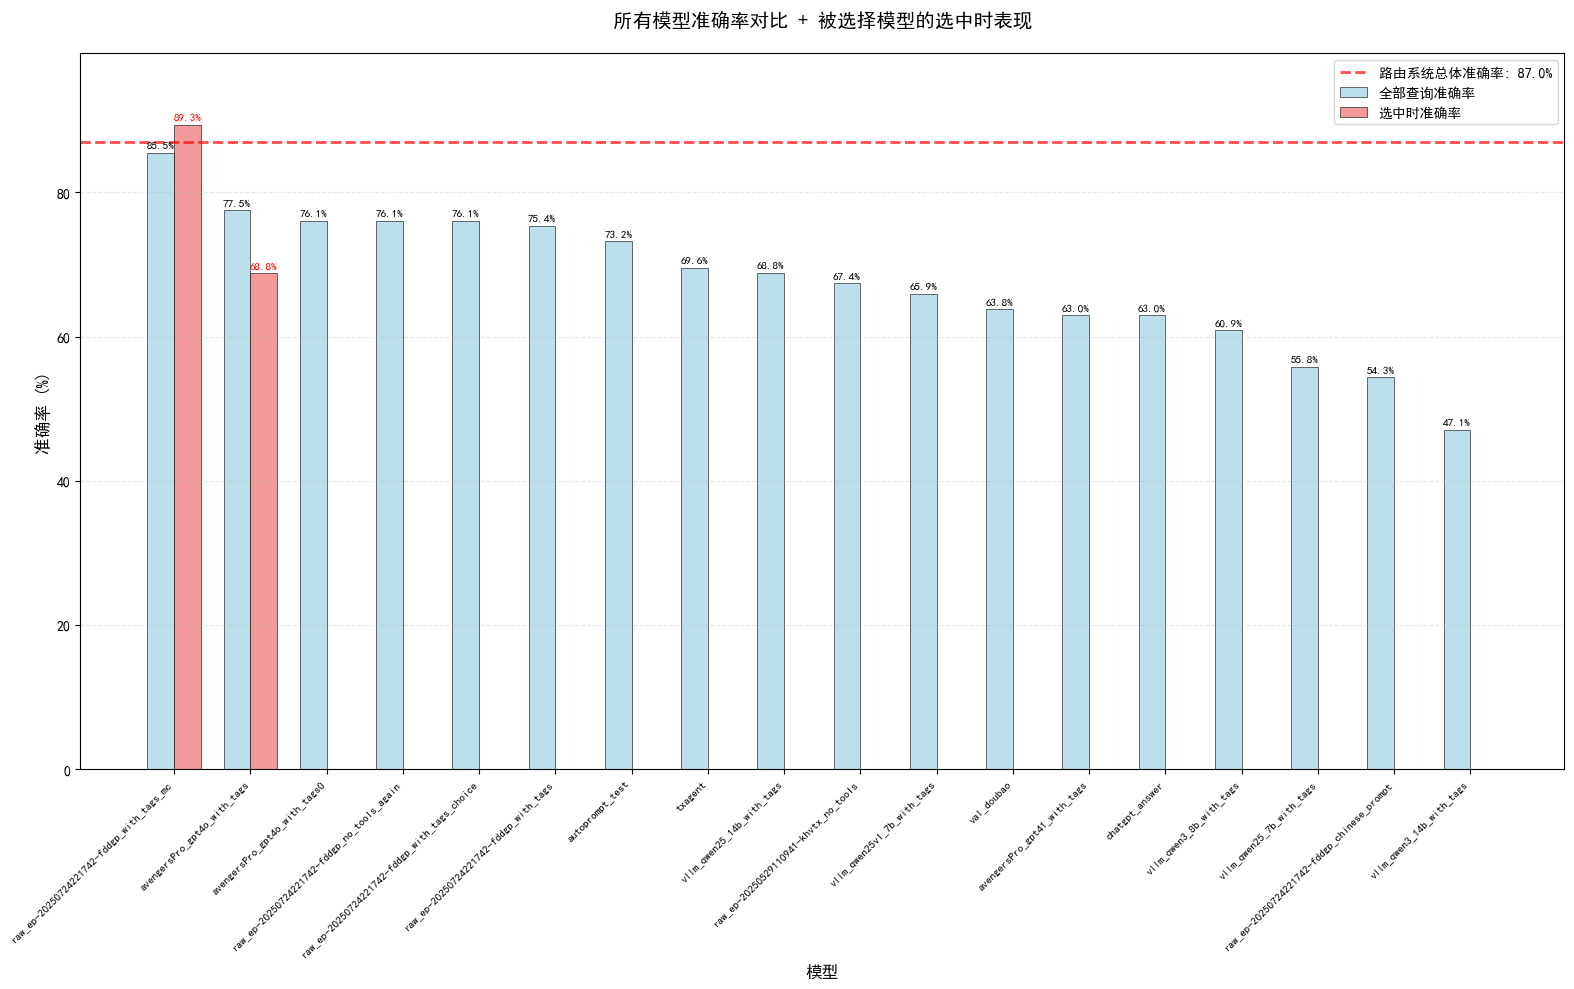

In [36]:
# 创建双柱状图：显示所有模型准确率 + 被选择模型的选中时准确率
fig, ax = plt.subplots(figsize=(16, 10))

# 准备数据
x_positions = np.arange(len(sorted_model_names))
bar_width = 0.35

# 所有模型的准确率（主柱）
bars1 = ax.bar(x_positions - bar_width/2, 
               [acc * 100 for acc in sorted_model_accuracies], 
               bar_width, 
               label='全部查询准确率',
               alpha=0.8,
               color='lightblue',
               edgecolor='black',
               linewidth=0.5)

# 被选择模型的选中时准确率（副柱）
selected_when_chosen_data = []
for model in sorted_model_names:
    if model in selected_when_chosen_accuracies:
        selected_when_chosen_data.append(selected_when_chosen_accuracies[model] * 100)
    else:
        selected_when_chosen_data.append(0)  # 未被选择的模型为0

bars2 = ax.bar(x_positions + bar_width/2, 
               selected_when_chosen_data, 
               bar_width, 
               label='选中时准确率',
               alpha=0.8,
               color='lightcoral',
               edgecolor='black',
               linewidth=0.5)

# 添加路由系统总体准确率参考线
ax.axhline(y=overall_accuracy * 100, color='red', linestyle='--', 
           linewidth=2, alpha=0.7, label=f'路由系统总体准确率: {overall_accuracy:.1%}')

# 设置图表属性
ax.set_xlabel('模型', fontsize=12, fontweight='bold')
ax.set_ylabel('准确率 (%)', fontsize=12, fontweight='bold')
ax.set_title('所有模型准确率对比 + 被选择模型的选中时表现', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x_positions)
ax.set_xticklabels(sorted_model_names, rotation=45, ha='right', fontsize=8)

# 添加数值标签
for i, (bar1, bar2, overall_acc, selected_acc) in enumerate(zip(bars1, bars2, sorted_model_accuracies, selected_when_chosen_data)):
    # 主柱标签
    height1 = bar1.get_height()
    ax.text(bar1.get_x() + bar1.get_width()/2., height1 + 0.5,
            f'{overall_acc:.1%}', ha='center', va='bottom', fontsize=8)
    
    # 副柱标签（只对被选择的模型显示）
    if selected_acc > 0:
        height2 = bar2.get_height()
        ax.text(bar2.get_x() + bar2.get_width()/2., height2 + 0.5,
                f'{selected_acc/100:.1%}', ha='center', va='bottom', fontsize=8, color='red')

# 添加网格和图例
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper right')

# 设置Y轴范围
y_max = max(max(sorted_model_accuracies), max([x/100 for x in selected_when_chosen_data if x > 0])) * 100
ax.set_ylim(0, y_max + 10)

plt.tight_layout()
plt.show()


In [37]:
# 深度分析：路由系统的选择策略
print("=== 路由选择策略分析 ===")

# 分析路由系统是否倾向于选择高准确率的模型
selected_models_list = list(model_selection_stats.keys())
selected_accuracies_list = [all_model_accuracies[model] for model in selected_models_list]
all_accuracies_list = list(all_model_accuracies.values())

avg_selected_accuracy = np.mean(selected_accuracies_list)
avg_all_accuracy = np.mean(all_accuracies_list)

print(f"被选择模型的平均准确率: {avg_selected_accuracy:.2%}")
print(f"所有模型的平均准确率: {avg_all_accuracy:.2%}")
print(f"选择偏好提升: {avg_selected_accuracy - avg_all_accuracy:+.1%}")

# 分析选中时表现 vs 总体表现
print(f"\n=== 选中时表现分析 ===")
for model in selected_models_list:
    overall_acc = all_model_accuracies[model]
    when_chosen_acc = selected_when_chosen_accuracies[model]
    difference = when_chosen_acc - overall_acc
    selection_count = model_selection_stats[model]
    
    print(f"{model}:")
    print(f"  选择次数: {selection_count}")
    print(f"  总体准确率: {overall_acc:.2%}")
    print(f"  选中时准确率: {when_chosen_acc:.2%}")
    print(f"  差异: {difference:+.1%}")
    print()

# 计算路由系统的智能程度
best_model_acc = max(all_model_accuracies.values())
worst_model_acc = min(all_model_accuracies.values())
random_selection_acc = avg_all_accuracy

print(f"=== 路由系统效果评估 ===")
print(f"最佳单模型准确率: {best_model_acc:.2%}")
print(f"最差单模型准确率: {worst_model_acc:.2%}")
print(f"随机选择期望准确率: {random_selection_acc:.2%}")
print(f"路由系统实际准确率: {overall_accuracy:.2%}")
print()
print(f"vs 最佳单模型: {overall_accuracy - best_model_acc:+.1%}")
print(f"vs 随机选择: {overall_accuracy - random_selection_acc:+.1%}")
print(f"vs 最差单模型: {overall_accuracy - worst_model_acc:+.1%}")


=== 路由选择策略分析 ===
被选择模型的平均准确率: 81.52%
所有模型的平均准确率: 67.75%
选择偏好提升: +13.8%

=== 选中时表现分析 ===
raw_ep-20250724221742-fddgp_with_tags_mc:
  选择次数: 122
  总体准确率: 85.51%
  选中时准确率: 89.34%
  差异: +3.8%

avengersPro_gpt4o_with_tags:
  选择次数: 16
  总体准确率: 77.54%
  选中时准确率: 68.75%
  差异: -8.8%

=== 路由系统效果评估 ===
最佳单模型准确率: 85.51%
最差单模型准确率: 47.10%
随机选择期望准确率: 67.75%
路由系统实际准确率: 86.96%

vs 最佳单模型: +1.4%
vs 随机选择: +19.2%
vs 最差单模型: +39.9%


完整准确率分析图已保存为:
- complete_model_accuracy_analysis.png
- complete_model_accuracy_analysis.pdf


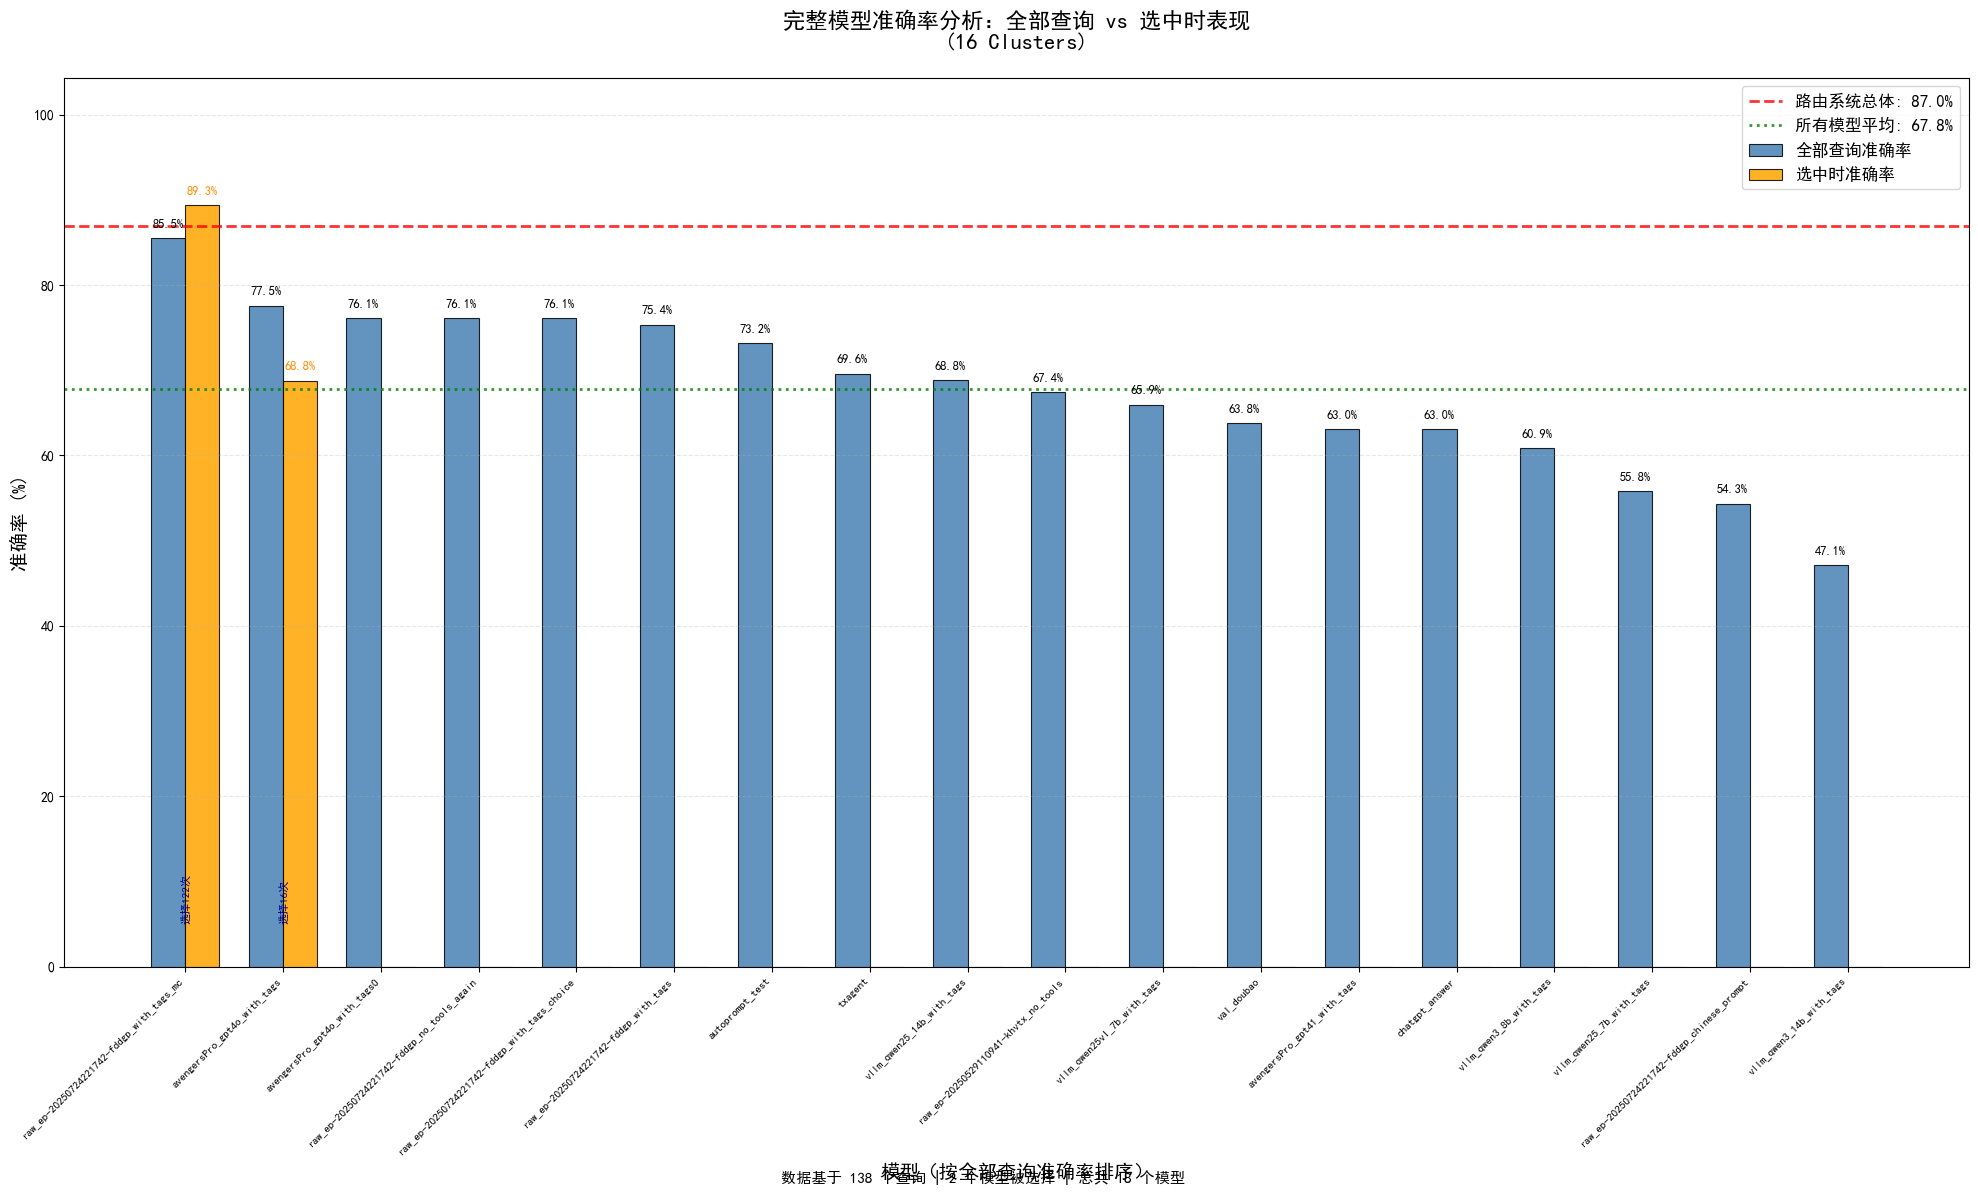

In [39]:
# 保存高质量图表
plt.figure(figsize=(20, 12))

# 准备数据
x_positions = np.arange(len(sorted_model_names))
bar_width = 0.35

# 创建双柱状图
bars1 = plt.bar(x_positions - bar_width/2, 
                [acc * 100 for acc in sorted_model_accuracies], 
                bar_width, 
                label='全部查询准确率',
                alpha=0.85,
                color='steelblue',
                edgecolor='black',
                linewidth=0.8)

# 被选择模型的选中时准确率
selected_when_chosen_data = []
for model in sorted_model_names:
    if model in selected_when_chosen_accuracies:
        selected_when_chosen_data.append(selected_when_chosen_accuracies[model] * 100)
    else:
        selected_when_chosen_data.append(0)

bars2 = plt.bar(x_positions + bar_width/2, 
                selected_when_chosen_data, 
                bar_width, 
                label='选中时准确率',
                alpha=0.85,
                color='orange',
                edgecolor='black',
                linewidth=0.8)

# 添加参考线
plt.axhline(y=overall_accuracy * 100, color='red', linestyle='--', 
            linewidth=2, alpha=0.8, label=f'路由系统总体: {overall_accuracy:.1%}')
plt.axhline(y=avg_all_accuracy * 100, color='green', linestyle=':', 
            linewidth=2, alpha=0.8, label=f'所有模型平均: {avg_all_accuracy:.1%}')

# 美化图表
plt.xlabel('模型（按全部查询准确率排序）', fontsize=14, fontweight='bold')
plt.ylabel('准确率 (%)', fontsize=14, fontweight='bold')
plt.title('完整模型准确率分析：全部查询 vs 选中时表现\n(16 Clusters)', 
          fontsize=16, fontweight='bold', pad=20)
plt.xticks(x_positions, sorted_model_names, rotation=45, ha='right', fontsize=8)

# 添加数值标签
for i, (bar1, bar2, overall_acc, selected_acc) in enumerate(zip(bars1, bars2, sorted_model_accuracies, selected_when_chosen_data)):
    # 主柱标签
    height1 = bar1.get_height()
    plt.text(bar1.get_x() + bar1.get_width()/2., height1 + 1,
             f'{overall_acc:.1%}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # 副柱标签（只对被选择的模型显示）
    if selected_acc > 0:
        height2 = bar2.get_height()
        plt.text(bar2.get_x() + bar2.get_width()/2., height2 + 1,
                 f'{selected_acc/100:.1%}', ha='center', va='bottom', 
                 fontsize=9, fontweight='bold', color='darkorange')

# 添加选择标记
for i, model in enumerate(sorted_model_names):
    if model in model_selection_stats:
        selection_count = model_selection_stats[model]
        plt.text(i, 5, f'选择{selection_count}次', ha='center', va='bottom', 
                rotation=90, fontsize=8, color='darkblue', fontweight='bold')

# 添加网格和图例
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.legend(loc='upper right', fontsize=12)

# 设置Y轴范围
y_max = max(max(sorted_model_accuracies), max([x/100 for x in selected_when_chosen_data if x > 0])) * 100
plt.ylim(0, y_max + 15)

# 添加说明文字
plt.figtext(0.5, 0.01, 
           f'数据基于 {total_queries} 个查询 | {len(model_selection_stats)} 个模型被选择 | 总共 {len(all_model_accuracies)} 个模型',
           ha='center', fontsize=11, style='italic')

plt.tight_layout()

# 保存图表
plt.savefig('complete_model_accuracy_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('complete_model_accuracy_analysis.pdf', bbox_inches='tight')

print("完整准确率分析图已保存为:")
print("- complete_model_accuracy_analysis.png")
print("- complete_model_accuracy_analysis.pdf")

plt.show()
